# SmartBeds - One-Class - Pruebas con otros datos
## Grado en Ingeniería Informática
## Universidad de Burgos
##### José Luis Garrido Labrador

In [1]:
import pandas as pd # se importa pandas como pd
import numpy as np  #numpy como np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import pickle as pk
from sklearn import metrics as mtr
from transformers import *

### Carga

In [2]:
with open('data/crisis_separadas.pkl','rb') as f:
    crisis_separadas = pk.load(f)

In [3]:
primera = crisis_separadas[0]
primera.head()

,DateTime,P1,P2,P3,P4,P5,P6,target
4089271,2018-11-09 21:03:27,4.098361,18.852459,21.311475,22.131148,13.114754,6.557377,False
4089270,2018-11-09 21:03:27,4.098361,18.852459,22.131148,22.131148,13.114754,6.557377,False
4089272,2018-11-09 21:03:28,4.918033,19.672131,22.131148,22.950820,13.934426,7.377049,False
4089273,2018-11-09 21:03:29,4.098361,18.852459,21.311475,22.131148,13.114754,6.557377,False
4089274,2018-11-09 21:03:30,0.000000,18.852459,22.131148,22.950820,13.114754,6.557377,False


In [4]:
primera_datos = primera.iloc[:,1:len(primera.columns)-1]
primera_datos.head()

,P1,P2,P3,P4,P5,P6
4089271,4.098361,18.852459,21.311475,22.131148,13.114754,6.557377
4089270,4.098361,18.852459,22.131148,22.131148,13.114754,6.557377
4089272,4.918033,19.672131,22.131148,22.950820,13.934426,7.377049
4089273,4.098361,18.852459,21.311475,22.131148,13.114754,6.557377
4089274,0.000000,18.852459,22.131148,22.950820,13.114754,6.557377


In [5]:
segunda = crisis_separadas[1]

start = pd.to_datetime("2019-01-29 06:12:04")
end = pd.to_datetime("2019-01-29 06:15:37")

mask = (segunda['DateTime'] < start) | (segunda['DateTime'] > end)
segunda.loc[mask,'target']=False

segunda.head()

,DateTime,P1,P2,P3,P4,P5,P6,target
6931232,2019-01-28 21:15:11,0.0,20.491803,18.032787,21.311475,9.016393,6.557377,False
6931233,2019-01-28 21:15:12,0.0,20.491803,18.032787,21.311475,9.016393,6.557377,False
6931234,2019-01-28 21:15:13,0.0,20.491803,18.032787,21.311475,9.016393,6.557377,False
6931235,2019-01-28 21:15:14,0.0,19.672131,18.032787,21.311475,9.836066,6.557377,False
6931236,2019-01-28 21:15:15,0.0,20.491803,18.852459,22.131148,9.836066,6.557377,False


In [6]:
segunda_datos = segunda.iloc[:,1:len(segunda.columns)-1]
segunda_datos.head()

,P1,P2,P3,P4,P5,P6
6931232,0.0,20.491803,18.032787,21.311475,9.016393,6.557377
6931233,0.0,20.491803,18.032787,21.311475,9.016393,6.557377
6931234,0.0,20.491803,18.032787,21.311475,9.016393,6.557377
6931235,0.0,19.672131,18.032787,21.311475,9.836066,6.557377
6931236,0.0,20.491803,18.852459,22.131148,9.836066,6.557377


In [7]:
tercera = crisis_separadas[2]
tercera.head()

,DateTime,P1,P2,P3,P4,P5,P6,target
2164084,2019-02-06 21:11:50,0.0,14.754098,27.049180,30.327869,10.655738,0.0,False
2164085,2019-02-06 21:11:51,0.0,15.573770,26.229508,24.590164,6.557377,0.0,False
2164087,2019-02-06 21:11:52,0.0,19.672131,29.508197,23.770492,4.918033,0.0,False
2164086,2019-02-06 21:11:52,0.0,18.032787,30.327869,27.049180,7.377049,0.0,False
2164088,2019-02-06 21:11:53,0.0,18.032787,25.409836,17.213115,0.000000,0.0,False


In [8]:
tercera_datos = tercera.iloc[:,1:len(tercera.columns)-1]
tercera_datos.head()

,P1,P2,P3,P4,P5,P6
2164084,0.0,14.754098,27.049180,30.327869,10.655738,0.0
2164085,0.0,15.573770,26.229508,24.590164,6.557377,0.0
2164087,0.0,19.672131,29.508197,23.770492,4.918033,0.0
2164086,0.0,18.032787,30.327869,27.049180,7.377049,0.0
2164088,0.0,18.032787,25.409836,17.213115,0.000000,0.0


### Transformers

In [9]:
svg = SavgolTransformer(15)
btr = ButterTransformer(3,0.05)
nor = Normalizer(max_=100)
avg = PipelineTransformer(StatisticsTransformer(mode='mean',window=25),nor)
std = PipelineTransformer(StatisticsTransformer(mode='std',window=25),nor)
ran = PipelineTransformer(StatisticsTransformer(mode='range',window=25),nor)
var = VarianceThresholdPD(threshold=0.5)
con = ConcatenateTransformer(avg,std,ran)
#Se quita el ajuste de varianza para mantener el mismo número de entradas
pps = PipelineTransformer(svg,con)
ppb = PipelineTransformer(btr,con)
ppr = PipelineTransformer(con)
ppr_s = PipelineTransformer(svg)
ppr_b = PipelineTransformer(btr)

#Reparador de targets
trT = MoveTargetsTransformer(window=25)

## Entrenamiento con primera crisis
### Brutos

In [10]:
with open('classifiers/RAW-seizure-classifier.pkl','rb') as f:
    raw_clf = pk.load(f)

In [11]:
predict = raw_clf.predict(segunda_datos)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

array([False, False, False, ..., False, False, False])

In [12]:
mtr.confusion_matrix(segunda['target'],predict)

array([[103893,      0],
       [   535,      0]])

0.33320744896506116


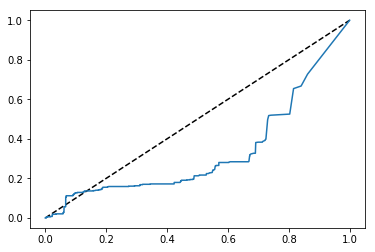

In [13]:
scr = raw_clf.score_samples(segunda_datos)
fpr, tpr, thr = mtr.roc_curve(segunda['target'],scr)
print(mtr.roc_auc_score(segunda['target'],scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

In [14]:
predict = raw_clf.predict(tercera_datos)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

array([False, False, False, ..., False, False, False])

In [15]:
mtr.confusion_matrix(tercera['target'],predict)

array([[86990,     0],
       [ 2741,     0]])

8.26269351354152e-07
0.30427739789352926


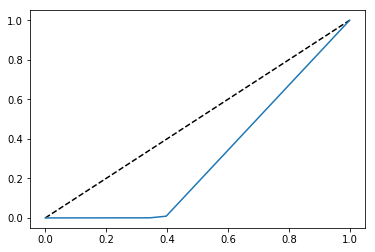

In [71]:
scr = raw_clf.score_samples(tercera_datos)
print(mtr.roc_auc_score(tercera['target'],scr))
fpr, tpr, thr = mtr.roc_curve(tercera['target'],scr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

### Estadísticos

In [17]:
with open('classifiers/STATS-seizure-classifier.pkl','rb') as f:
    sts_clf = pk.load(f)

In [18]:
prd = con.fit_transform(segunda_datos).dropna()
predict = sts_clf.predict(prd)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

array([False, False, False, ..., False, False, False])

In [19]:
target = trT.fit_transform((pd.concat((prd,segunda['target']),axis=1)).dropna())

target = target['target']
target.head()

6931256    False
6931257    False
6931258    False
6931259    False
6931260    False
Name: target, dtype: bool

In [20]:
mtr.confusion_matrix(target,predict)

array([[103894,      0],
       [   510,      0]])

0.0
0.5


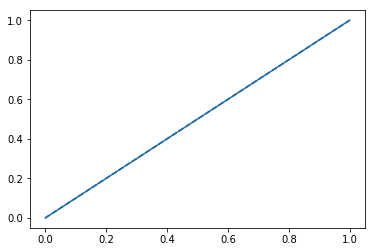

In [74]:
scr = sts_clf.score_samples(prd)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

In [22]:
prd = con.fit_transform(tercera_datos).dropna()
predict = sts_clf.predict(prd)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

array([False, False, False, ..., False, False, False])

In [23]:
target = trT.fit_transform((pd.concat((prd,tercera['target']),axis=1)).dropna())

target = target['target']
target.head()

2164108    False
2164109    False
2164110    False
2164111    False
2164112    False
Name: target, dtype: bool

In [24]:
mtr.confusion_matrix(target,predict)

array([[86975,     0],
       [ 2732,     0]])

0.5


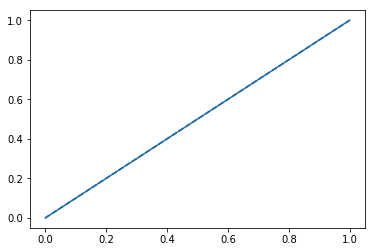

In [25]:
scr = sts_clf.score_samples(prd)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

### SavGol

In [26]:
with open('classifiers/SAVGOL-seizure-classifier.pkl','rb') as f:
    sav_clf = pk.load(f)

In [27]:
sav = ppr_s.fit_transform(segunda_datos).dropna()
predict = sav_clf.predict(sav)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

/usr/local/anaconda3/envs/TFG/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([False, False, False, ..., False, False, False])

In [28]:
target = (pd.concat((sav,segunda['target']),axis=1)).dropna()['target']
target.head()

6931232    False
6931233    False
6931234    False
6931235    False
6931236    False
Name: target, dtype: bool

In [29]:
mtr.confusion_matrix(target,predict)

array([[103893,      0],
       [   535,      0]])

0.28239700425068887


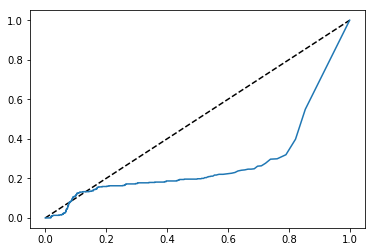

In [30]:
scr = sav_clf.score_samples(sav)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

In [31]:
sav = ppr_s.fit_transform(tercera_datos).dropna()
predict = sav_clf.predict(sav)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

/usr/local/anaconda3/envs/TFG/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([False, False, False, ..., False, False, False])

In [32]:
target = (pd.concat((sav,tercera['target']),axis=1)).dropna()['target']
target.head()

2164084    False
2164085    False
2164087    False
2164086    False
2164088    False
Name: target, dtype: bool

In [33]:
mtr.confusion_matrix(target,predict)

array([[86990,     0],
       [ 2741,     0]])

0.33407862972755487


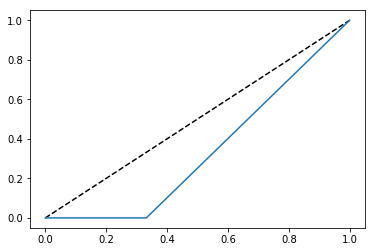

In [34]:
scr = sav_clf.score_samples(sav)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

### Butter

In [35]:
with open('classifiers/BUTTER-seizure-classifier.pkl','rb') as f:
    btt_clf = pk.load(f)

In [36]:
but = ppr_b.fit_transform(segunda_datos).dropna()
predict = btt_clf.predict(but)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

/usr/local/anaconda3/envs/TFG/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([False, False, False, ..., False, False, False])

In [37]:
target = (pd.concat((but,segunda['target']),axis=1)).dropna()['target']
target.head()

6931232    False
6931233    False
6931234    False
6931235    False
6931236    False
Name: target, dtype: bool

In [38]:
mtr.confusion_matrix(target,predict)

array([[103893,      0],
       [   535,      0]])

0.29574017156940124


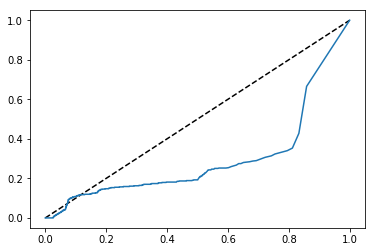

In [39]:
scr = btt_clf.score_samples(but)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

In [40]:
but = ppr_b.fit_transform(tercera_datos).dropna()
predict = btt_clf.predict(but)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

/usr/local/anaconda3/envs/TFG/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([False, False, False, ..., False, False, False])

In [41]:
target = (pd.concat((but,tercera['target']),axis=1)).dropna()['target']
target.head()

2164084    False
2164085    False
2164087    False
2164086    False
2164088    False
Name: target, dtype: bool

In [42]:
mtr.confusion_matrix(target,predict)

array([[86990,     0],
       [ 2741,     0]])

0.3324462581905966


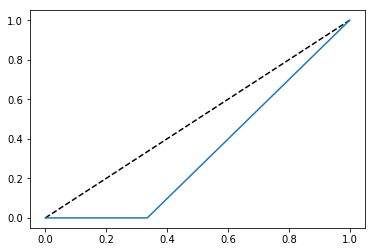

In [43]:
scr = btt_clf.score_samples(but)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

### SavGol Estadísticos

In [44]:
with open('classifiers/SAVGOL-STATS-seizure-classifier.pkl','rb') as f:
    sts_clf = pk.load(f)

In [45]:
sst = pps.fit_transform(segunda_datos).dropna()
predict = sts_clf.predict(sst)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

/usr/local/anaconda3/envs/TFG/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([False, False, False, ..., False, False, False])

In [46]:
target = trT.fit_transform((pd.concat((sst,segunda['target']),axis=1)).dropna())

target = target['target']
target.head()

6931256    False
6931257    False
6931258    False
6931259    False
6931260    False
Name: target, dtype: bool

In [47]:
mtr.confusion_matrix(target,predict)

array([[103894,      0],
       [   510,      0]])

0.5


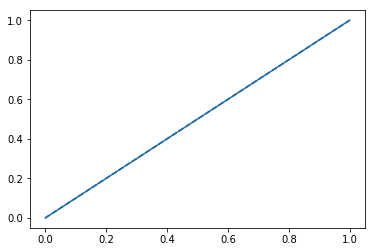

In [48]:
scr = sts_clf.score_samples(sst)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

In [49]:
sst = pps.fit_transform(tercera_datos).dropna()
predict = sts_clf.predict(sst)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

/usr/local/anaconda3/envs/TFG/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([False, False, False, ..., False, False, False])

In [50]:
target = trT.fit_transform((pd.concat((sst,tercera['target']),axis=1)).dropna())

target = target['target']
target.head()

2164108    False
2164109    False
2164110    False
2164111    False
2164112    False
Name: target, dtype: bool

In [51]:
mtr.confusion_matrix(target,predict)

array([[86975,     0],
       [ 2732,     0]])

0.5


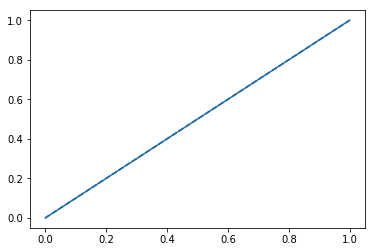

In [52]:
scr = sts_clf.score_samples(sst)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

### Butter Estadísticos

In [53]:
with open('classifiers/BUTTER_STATS-seizure-classifier.pkl','rb') as f:
    bts_clf = pk.load(f)

In [54]:
bts = ppb.fit_transform(segunda_datos).dropna()
predict = bts_clf.predict(bts)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

/usr/local/anaconda3/envs/TFG/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([False, False, False, ..., False, False, False])

In [55]:
target = trT.fit_transform((pd.concat((bts,segunda['target']),axis=1)).dropna())

target = target['target']
target.head()

6931256    False
6931257    False
6931258    False
6931259    False
6931260    False
Name: target, dtype: bool

In [56]:
mtr.confusion_matrix(target,predict)

array([[103894,      0],
       [   510,      0]])

0.5


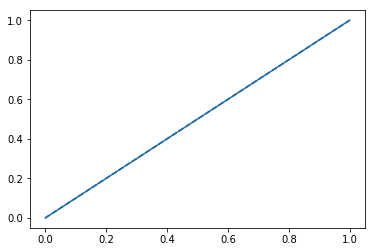

In [57]:
scr = bts_clf.score_samples(bts)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)

In [58]:
bts = ppb.fit_transform(tercera_datos).dropna()
predict = bts_clf.predict(bts)
predict[predict==-1]=0
predict = predict.astype('bool')
predict

/usr/local/anaconda3/envs/TFG/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([False, False, False, ..., False, False, False])

In [59]:
target = trT.fit_transform((pd.concat((bts,tercera['target']),axis=1)).dropna())

target = target['target']
target.head()

2164108    False
2164109    False
2164110    False
2164111    False
2164112    False
Name: target, dtype: bool

In [60]:
mtr.confusion_matrix(target,predict)

array([[86975,     0],
       [ 2732,     0]])

0.5


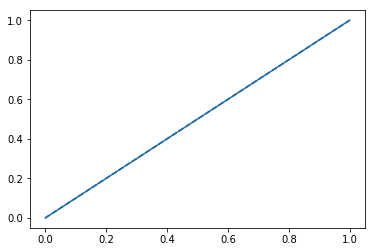

In [61]:
scr = bts_clf.score_samples(bts)
fpr, tpr, thr = mtr.roc_curve(target,scr)
print(mtr.roc_auc_score(target,scr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)